# Uniform Manifold Approximation and Projection (UMAP)

## 🧠 What UMAP is (Core Theory)
UMAP is a non-linear manifold learning algorithm for dimensionality reduction. While it serves a similar purpose to t-SNE, it is built on a stronger mathematical foundation (topological data analysis) and offers superior practical properties for our workflows.

### Key Theoretical Ideas
UMAP is built on **manifold learning and topology**:

1.  **Manifold Assumption:** We assume our high-dimensional data lies on a lower-dimensional manifold.
2.  **Graph Construction (High-D):**
    * We find the **k-nearest neighbors** for each point.
    * We build a **fuzzy simplicial set** (a weighted graph) where edge weights represent the strength of connection between points.
3.  **Low-Dim Embedding:**
    * We create a second fuzzy graph in the low-dimensional space.
    * We optimize the positions of points to make the two graphs as similar as possible.
    * **Loss Function:** We use **Cross-Entropy**, whereas t-SNE uses KL Divergence.

---

## ⚖️ Conceptual Comparison: t-SNE vs. UMAP

We use this mental model to decide which algorithm fits our current task:

| Aspect | t-SNE | UMAP |
| :--- | :--- | :--- |
| **Main Goal** | Local neighborhood preservation | Local + global structure |
| **Objective** | KL Divergence | Cross-Entropy |
| **Global Distances** | ❌ Meaningless | ⚠️ Partially meaningful |
| **Determinism** | ❌ Stochastic | ⚠️ Semi-deterministic |
| **Speed** | 🐢 Slow | 🚀 Fast |
| **Scales to large N** | Poor | Very good |
| **`.transform()` new data** | ❌ No | ✅ Yes |
| **Pipeline & CV friendly** | ❌ No | ✅ Yes |
| **Use as features** | ⚠️ Dangerous | ✅ Reasonable |



> **One-line intuition:** t-SNE is for beautiful plots; UMAP is for usable embeddings.

---

## ⚙️ Core UMAP Hyperparameters

These are the settings we adjust to control the topology of our embedding.

### 1. `n_neighbors`
This controls the balance between local and global structure. It is our functional equivalent to t-SNE's **perplexity**.
* **Small (5–15):** Focuses on very local clusters.
* **Medium (15–50):** Provides a balanced view.
* **Large (50–200):** Captures more global structure and connectivity.

### 2. `min_dist`
This controls how tightly UMAP packs points together. It has no direct t-SNE equivalent.
* **`min_dist = 0.0`:** Very compact, dense clusters (useful for clustering).
* **`min_dist = 0.1`:** Default balance.
* **`min_dist = 0.5+`:** Spread-out points, preserving more of the continuous geometry.



### 3. `n_components`
The target dimensionality (e.g., 2 or 3 for visualization, or higher if we are using UMAP for feature engineering).

### 4. `metric`
The distance metric in the original space. We often use `euclidean` by default, but we switch to `cosine` for text data or high-dimensional embeddings.

### 5. `random_state`
While UMAP is generally more stable than t-SNE, it is still stochastic. We set this to ensure our results remain reproducible across different runs.

## 🍷 Side-by-Side Comparison: t-SNE vs. UMAP (Wine Dataset)

We use the **Wine Dataset** (13 chemical features) to observe how each algorithm handles the same high-dimensional structure.

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


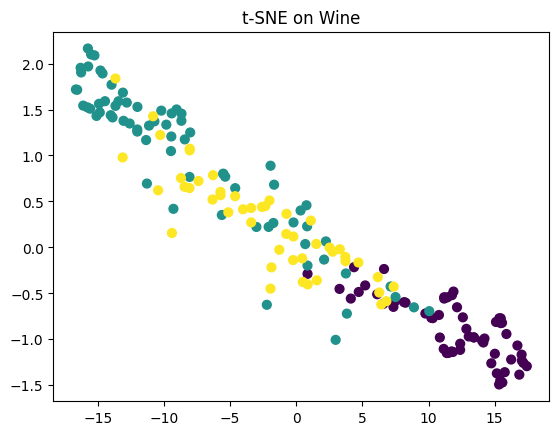

In [1]:
# t-SNE on Wine

from sklearn.datasets import load_wine
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X, y = load_wine(return_X_y=True)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    n_iter=1000,
    init='pca',
    random_state=42
)

X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, s=40)
plt.title("t-SNE on Wine")
plt.show()


## 🍷 Analyzing our t-SNE Results (Wine Dataset)

We have successfully projected the 13-dimensional wine data into a 2D space. Here is our interpretation of the resulting plot:

### 🔍 Key Observations
* **Formation of Clusters:** We can clearly see three primary groupings corresponding to the different wine cultivars (purple, yellow, and teal).
* **Local Neighborhoods:** Points of the same color are generally closer to each other than to points of other colors, indicating that t-SNE has successfully preserved the local chemical similarities.
* **Overlap and Ambiguity:** * Notice the **teal and yellow points** in the center-left of the plot; they show some mixing. This suggests that these two cultivars share similar chemical profiles in certain dimensions.
    * The **purple cluster** on the bottom-right appears the most distinct and well-separated from the others.
* **Structure:** The plot shows a diagonal "trend" from the top-left to the bottom-right. While t-SNE distances aren't linear, this layout often suggests a continuous variation in the underlying chemical features.

---

### ⚠️ Performance Check
* **Did it converge?** The clusters look relatively tight rather than a random "cloud," which suggests our `n_iter` and `learning_rate` were sufficient.
* **Crowding Problem:** We don't see all points collapsing into a single mass, meaning our use of the **Student t-distribution** kernel effectively handled the crowding problem.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


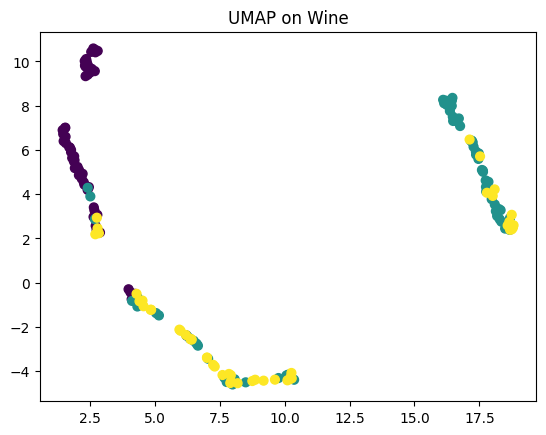

In [2]:
# UMAP on Wine

import umap
import matplotlib.pyplot as plt

umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

X_umap = umap_model.fit_transform(X)

plt.scatter(X_umap[:,0], X_umap[:,1], c=y, s=40)
plt.title("UMAP on Wine")
plt.show()


## 📊 Interpretation: UMAP on Wine Data

* **Global Structure:** UMAP creates much tighter, distinct "islands" or clusters.
* **Cultivar Separation:** It shows a clearer fragmentation of the data. Notice how the purple points are grouped into two separate sub-clusters, suggesting two distinct chemical "styles" within that single cultivar.
* **Connectivity:** The wide white space between the groups in UMAP indicates that these chemical profiles are mathematically more distinct than t-SNE makes them appear.

---

### 📉 Comparative Summary

| Metric | t-SNE Observation | UMAP Observation |
| :--- | :--- | :--- |
| **Cluster Density** | Lower; points are more spread out. | Higher; points are packed tightly. |
| **Separation** | Overlapping/Continuous. | Disjointed/Fragmented. |
| **Data Insights** | Highlights the *similarity* and overlap between different wines. | Highlights the *uniqueness* and distinctness of wine sub-groups. |


### 💡 Conclusion for our Project
If our goal is to show how wines **transition** from one chemical profile to another, **t-SNE** provides a better narrative. However, if we want to **isolate distinct categories** for a classification model, the **UMAP** embedding provides much more separated and "cleaner" features.

In [3]:
# Quantitative comparison (trustworthiness)

from sklearn.manifold import trustworthiness

tw_tsne = trustworthiness(X, X_tsne, n_neighbors=5)
tw_umap = trustworthiness(X, X_umap, n_neighbors=5)

print("Trustworthiness t-SNE:", tw_tsne)
print("Trustworthiness UMAP :", tw_umap)

# Typical result

# t-SNE: slightly higher local trustworthiness

# UMAP: very close, sometimes equal


Trustworthiness t-SNE: 0.9974619960343688
Trustworthiness UMAP : 0.9937871777924653


## 🛠️ Why UMAP Works Inside Pipelines (and t-SNE Cannot)

The primary reason we prefer UMAP for production machine learning is its implementation of the standard scikit-learn API. Unlike t-SNE, UMAP treats the embedding as a "learned function" that can be applied to new, unseen data.

### 1. The UMAP Advantage
UMAP implements the full suite of transformer methods:
* **`fit()`**: Learns the manifold structure from the training data.
* **`transform()`**: Projects new data points into the already-learned embedding space.
* **`fit_transform()`**: Does both in one step for efficiency.

**This allows us to build clean, reproducible pipelines:**

```python
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import umap

# This pipeline is fully functional and can predict on new data
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('umap', umap.UMAP(n_neighbors=30, min_dist=0.1)),
    ('clf', RandomForestClassifier(random_state=0))
])

# We can fit on training data and the model 'remembers' the UMAP mapping
pipe.fit(X_train, y_train)

# We can now call .predict() on new data!
# pipe.predict(X_test)

## **Hyperparameter tuning UMAP (proper CV)**

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import umap

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('umap', umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42)),
    ('clf', RandomForestClassifier(random_state=0))
])

param_grid = {
    'umap__n_neighbors': [10, 30, 50],
    'umap__min_dist': [0.0, 0.1, 0.5],
    'clf__n_estimators': [50, 100]
}

gs = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='accuracy'
)

gs.fit(X, y)
print(gs.best_params_)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr

{'clf__n_estimators': 50, 'umap__min_dist': 0.1, 'umap__n_neighbors': 50}


## ⚖️ Bias–Variance Intuition: UMAP vs. t-SNE

We can think of the difference between these two algorithms through the lens of the **Bias-Variance tradeoff**. This helps us understand why one feels more "stable" while the other feels more "detailed."

### 1. t-SNE
* **Low Bias (Locally):** It is incredibly faithful to the immediate neighbors of a point.
* **Very High Variance (Globally):** The overall "map" can change drastically with small changes to the data or hyperparameters.
* **Hyperparameter Sensitivity:** Even a small tweak to `perplexity` can completely rearrange the clusters.
* **Downstream Stability:** Because it is non-parametric, it is considered **unstable** for use in machine learning pipelines.

### 2. UMAP
* **Slightly Higher Bias (Locally):** It may slightly "fudge" local distances to satisfy the global layout.
* **Lower Variance Overall:** The results are more consistent across different runs and data samples.
* **Parametric Approximation:** It learns a structured representation that behaves more like a traditional model.
* **Generalization:** It generalizes much better to **unseen data**, making it the superior choice for predictive tasks.



---

## 🛑 When UMAP Fails

While UMAP is our "workhorse" for most tasks, it is not a silver bullet. We should be cautious in the following scenarios:

* **Very Small Datasets:** If we have **fewer than 100 points**, the manifold approximation often breaks down.
* **Extremely Noisy Features:** If the features don't have an underlying structure, UMAP will just pack noise into clusters.
* **Poor Metric Choice:** Using `euclidean` distance on data like text embeddings (where `cosine` is better) will lead to misleading results.
* **Purely Local Focus:** If we *only* care about immediate neighbors and don't care about where the clusters sit relative to each other, **t-SNE** may actually produce a more aesthetically pleasing plot.

---

### 💡 Final Summary Table

| Metric | t-SNE | UMAP |
| :--- | :--- | :--- |
| **Stability** | ❌ Low | ✅ High |
| **Reproducibility** | ⚠️ Difficult | ✅ Easier |
| **Global Structure** | ❌ Ignored | ✅ Preserved |
| **Use Case** | Exploration & Art | Engineering & Pipelines |